## 목차

 1. [데이터 로딩](#1.-데이터-로딩)
 
 
 2. [회귀분석](#2.-회귀분석) <br>
    a. [선형회귀모형](#b.-선형회귀모형) <br>
    b. [릿지 회귀모형](#b.-릿지-회귀모형) <br>
    c. [라쏘 회귀모형](#b.-라쏘-회귀모형)
    
    
 3. [랜덤포레스트](#3.-랜덤포레스트)

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler 

import statsmodels.api as sm # OLS선형회귀분석
from sklearn.metrics import mean_squared_error

참고 : https://datascienceschool.net/view-notebook/58269d7f52bd49879965cdc4721da42d/ <br>
https://wikidocs.net/44450

## 1. 데이터 로딩

In [3]:
busan_2017 = pd.read_csv("../input/busan_2017.csv", encoding="cp949")
busan_2018 = pd.read_csv("../input/busan_2018.csv", encoding="cp949")
busan_2019 = pd.read_csv("../input/busan_2019.csv", encoding="cp949")

In [4]:
seoul_2017 = pd.read_csv("../input/seoul_2017.csv", encoding="cp949")
seoul_2018 = pd.read_csv("../input/seoul_2018.csv", encoding="cp949")
seoul_2019 = pd.read_csv("../input/seoul_2019.csv", encoding="cp949")

In [5]:
busan = pd.concat([busan_2017, busan_2018, busan_2019]) # 부산 병합
seoul = pd.concat([seoul_2017, seoul_2018, seoul_2019]) # 서울 병합

In [6]:
b_dict = { 'price' : busan['거래금액(만원)'],
          'city' : busan['시군구'],
          'se' : busan['단지명'],
          'area' : busan['전용면적(㎡)'],
          'mon' : busan['계약년월'],
          'day' : busan['계약일'],
          'floor' : busan['층'],
          'build' : busan['건축년도'] }

s_dict = { 'price' : seoul['거래금액(만원)'],
          'city' : seoul['시군구'],
          'se' : seoul['단지명'],
          'area' : seoul['전용면적(㎡)'],
          'mon' : seoul['계약년월'],
          'day' : seoul['계약일'],
          'floor' : seoul['층'],
          'build' : seoul['건축년도'] }

busan = pd.DataFrame(b_dict)
seoul = pd.DataFrame(s_dict)

busan.reset_index(drop=True, inplace=True)
seoul.reset_index(drop=True, inplace=True)
print("index reset 완료")

index reset 완료


In [7]:
#부산 구 단위
b_si = []
b_gu = []
b_dong = []
for i in range(len(busan)):
    b = busan.loc[:,'city'][i].split()
    b_si.append(b[0])
    b_gu.append(b[0] + " " + b[1])
    b_dong.append(b[0] + " " + b[1] + " " + b[2])
print(len(b_si), len(b_gu), len(b_dong))

busan["si"] = b_si
busan["gu"] = b_gu
busan["dong"] = b_dong


# 서울 구 단위
s_si = []
s_gu = []
s_dong = []
for i in range(len(seoul)):
    s = seoul.loc[:,'city'][i].split()
    s_si.append(s[0])
    s_gu.append(s[0] + " " + s[1])
    s_dong.append(s[0] + " " + s[1] + " " + s[2])
print(len(s_si), len(s_gu), len(s_dong))

seoul["si"] = s_si
seoul["gu"] = s_gu
seoul["dong"] = s_dong

print("부산, 서울 도시 별로 split 완료")

99614 99614 99614
261314 261314 261314
부산, 서울 도시 별로 split 완료


In [8]:
# 데이터 병합
data = pd.concat([busan, seoul])

# 데이터 재 인덱싱
data.reset_index(drop=True, inplace=True)

#데이터 재정렬
data = data[['price','area', 'mon', 'day', 'floor', 'build', 'gu', 'dong', 'si', 'se', 'city']]
del data["city"]

print(data.shape)
print(data.columns)
data.tail(3)

(360928, 10)
Index(['price', 'area', 'mon', 'day', 'floor', 'build', 'gu', 'dong', 'si',
       'se'],
      dtype='object')


,price,area,mon,day,floor,build,gu,dong,si,se
360925,25800,57.18,201905,20,6,2003,서울특별시 중랑구,서울특별시 중랑구 중화동,서울특별시,한영(102)
360926,34500,82.17,201901,31,7,2007,서울특별시 중랑구,서울특별시 중랑구 중화동,서울특별시,현대휴앤미
360927,32800,64.48,201907,15,3,2007,서울특별시 중랑구,서울특별시 중랑구 중화동,서울특별시,현대휴앤미(102동)


In [9]:
# X, Y값 설정
X = data.iloc[:,1:7]
print(X[:3])

Y = data.iloc[:,0]
print(Y[:3])

      area     mon  day  floor  build         gu
0  72.5242  201710    1      6   2017  부산광역시 강서구
1  72.5242  201710    2      3   2017  부산광역시 강서구
2  62.2475  201710   24      5   2017  부산광역시 강서구
0    20500
1    20500
2    19000
Name: price, dtype: int64


In [29]:
# 분석을 위한 데이터 분리 : HoldOut방법
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=256)
print(X_train.shape)
print(Y_train[:3])
X_train[:3]

(252649, 6)
2680     32900
83253     7520
84121    12150
Name: price, dtype: int64


,area,mon,day,floor,build,gu
2680,59.813,201711,1,22,1998,부산광역시 금정구
83253,50.430,201911,24,4,1992,부산광역시 사상구
84121,52.560,201908,30,2,1984,부산광역시 사상구


In [ ]:
# 이상치 제거


# 가변수 처리




## 2. 회귀분석

### a. 선형회귀모형
- OLS을 이용한 선형회귀분석

In [11]:
X_train['intercept'] = 1
lm = sm.OLS(Y_train, X_train[['intercept','area','mon','day','floor','build']]) # 잏단 '구'를 제거하고 분석하였음
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                 2.588e+04
Date:                Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:30:41   Log-Likelihood:            -3.0226e+06
No. Observations:              252649   AIC:                         6.045e+06
Df Residuals:                  252643   BIC:                         6.045e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.364e+07   1.82e+05    -75.105      0.000    -1.4e+07   -1.33e+07
area         878.5331      2.544    345.294      0.000     873.546     883.520
mon           68.7642      0.901     76.314      0.000      66.998      70.530
day           40.5466      8.648      4.688      0.000      23.597      57.497
floor        258.9392     11.698     22.136      0.000     236.012     281.867
build       -126.7085      7.698    -16.459      0.000    -141.797    -111.620
==============================================================================
Omnibus:                   133013.298   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1742176.177
Skew:                           2.242   Prob(JB):                         0.00
Kurtosis:                      15.057   Cond. No.                     4.85e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.85e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> 다중공선성 분석이 필요! <br>
  다중공선성 : 종속변수를 제외한 독립변수들 간에 강한 상관관계가 나타나는 문제
  >> 다중공선성이 존재하면 선형모형에 좋지 않은 영향을 미치므로, 반드시 변수 선별이 필요함

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
train_X_df = X_train.iloc[:,:-2]
train_X_df
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_X_df.values, i) for i in range(train_X_df.shape[1])]
vif["features"] = train_X_df.columns
vif

,VIF Factor,features
0,7.956631,area
1,41330.510666,mon
2,4.340339,day
3,3.271560,floor
4,41493.382224,build


In [13]:
train_X_df = X_train[['area','day','floor']] # 다중공선성 : 값이 10 이상인 경우 해당 변수 제외
train_X_df
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_X_df.values, i) for i in range(train_X_df.shape[1])]
vif["features"] = train_X_df.columns
vif

,VIF Factor,features
0,4.150032,area
1,3.169014,day
2,2.807078,floor


In [14]:
lm = sm.OLS(Y_train, X_train[['intercept','area','day','floor']])
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                 4.019e+04
Date:                Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:30:42   Log-Likelihood:            -3.0256e+06
No. Observations:              252649   AIC:                         6.051e+06
Df Residuals:                  252645   BIC:                         6.051e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.352e+04    267.105    -50.630      0.000    -1.4e+04    -1.3e+04
area         874.3250      2.573    339.843      0.000     869.283     879.368
day           38.4289      8.750      4.392      0.000      21.280      55.578
floor        245.5890     11.499     21.357      0.000     223.051     268.127
==============================================================================
Omnibus:                   136873.932   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1796910.784
Skew:                           2.330   Prob(JB):                         0.00
Kurtosis:                      15.206   Cond. No.                         299.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
X_test['intercept'] = 1
pred_y = model.predict(X_test[['intercept','area','day','floor']])
residual = Y_test - pred_y 
print("잔차")
residual.describe()

잔차


count    108279.000000
mean       -169.822632
std       38342.334801
min     -145295.187038
25%      -21736.774185
50%       -6993.671110
75%       11114.453464
max      578190.405975
dtype: float64

In [16]:
mse = mean_squared_error(pred_y, Y_test)
rmse = mse ** 0.5
print("MSE =", mse)
print("RMSE =", rmse)

MSE = 1470149900.4295828
RMSE = 38342.53382902052


### b. 릿지 회귀모형
- Ridge 회귀분석
https://bskyvision.com/687?category=751609

In [17]:
from sklearn.linear_model import Ridge
ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train[['area','day','floor']], Y_train)
pred_y = ridgeReg.predict(X_test[['area','day','floor']])
score = ridgeReg.score(X_train[['area','day','floor']], Y_train)
mse = mean_squared_error(pred_y, Y_test)
rmse = mse ** 0.5
print("R_Squared =", score)
print("MSE =", mse)
print("RMSE =", rmse)

R_Squared = 0.32232322432683036
MSE = 1472378259.599405
RMSE = 38371.581406027624


### b. 라쏘 회귀모형
- Lasso 회귀분석 https://bskyvision.com/688?category=751609

In [18]:
from sklearn.linear_model import Lasso
lassoReg = Lasso(alpha=0.05, normalize=True)
lassoReg.fit(X_train[['area','day','floor']], Y_train)
pred_y = lassoReg.predict(X_test[['area','day','floor']])
score = lassoReg.score(X_train[['area','day','floor']], Y_train)
mse = mean_squared_error(pred_y, Y_test)
rmse = mse ** 0.5
print("R_Squared =", score)
print("MSE =", mse)
print("RMSE =", rmse)

R_Squared = 0.3230422667147047
MSE = 1470184660.049268
RMSE = 38342.98710389252


>  이상치를 제거하고 가변수 처리를 해봐야 정확히 알겠지만, 선형회귀분석은, 이 데이터를 분석하기에는 그리 좋은 모델이 아님. 다른 방식이 필요함.

## 3. 랜덤포레스트

In [36]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=256)
X_train = X_train.iloc[:,:-1] # 잏단 '구'를 제거하고 분석하였음
Y_train = Y_train
print(X_train.shape)
print(Y_train.shape)

model.fit(X_train, Y_train)
pred_y = model.predict(X_test.iloc[:,:-1])
print(pred_y.shape, Y_test.shape)

(252649, 5)
(252649,)
(108279,) (108279,)


[Text(0.5, 1.0, 'Predict')]

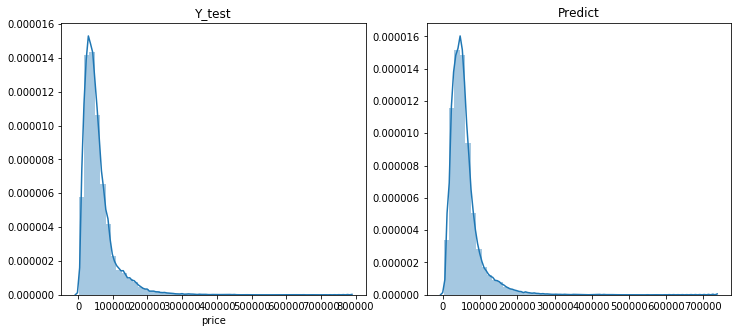

In [53]:
fig, (ax1,ax2)= plt.subplots(ncols=2)

fig.set_size_inches(12,5)

sns.distplot(Y_test, ax=ax1, bins=50)
ax1.set(title="Y_test")

sns.distplot(pred_y, ax=ax2, bins=50)
ax2.set(title="Predict")

In [54]:
from sklearn.metrics import r2_score

accuracy = r2_score(pred_y, Y_test)
print("Randomforest_Regression_정확도 :",accuracy)

Randomforest_Regression_정확도 : 0.7714673749263437


> 성능 향상을 위해 선형회귀분석 이전으로 돌아가 이상치 제거, 가변수 처리가 필요해보임. 차후 추가 예정. <br>
이상치, 가변수 처리 이후 성능이 더이상 나아지지 않으면 추가적으로 아래 주소의 XGBOOST를 사용해 볼 예정임. <br>
https://nonmeyet.tistory.com/entry/Python-%EC%A7%91%EA%B0%92-%EC%98%88%EC%B8%A1-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EA%B8%B0-%EC%BA%90%EA%B8%80-House-Prices-Regression-4

[▲처음으로 돌아가기](#목차)

<a href="./1_EDA.ipynb"> ☞ 1번째 파일 바로가기 <a>